### Import Requird Libraries


In [7]:
import configparser
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import zscore
import numpy as np

### Get Database settings and connect to DataBase

In [10]:
config = configparser.ConfigParser()
config.read("settings.cfg")
host_cfg = config.get('youtubeapi_Database_Credentials', 'host')
database_cfg = config.get('youtubeapi_Database_Credentials', 'database')
user_cfg = config.get('youtubeapi_Database_Credentials', 'user')
pswrd_cfg = config.get('youtubeapi_Database_Credentials', 'password')
try:
    conn = psycopg2.connect(
    host=host_cfg,
    database=database_cfg,
    user=user_cfg,
    password=pswrd_cfg)
except psycopg2.DatabaseError as err:
    print(err)
cur = conn.cursor()


### Retrieve data from Database and create DataFrame

#### Get the video_details table 

In [11]:
cur.execute("SELECT * FROM video_details")
cols = ['id', 'video_id','views','likes','dislikes','date_time']

df_48h = pd.DataFrame(cur.fetchall(),columns= cols)

#### Get the videos table 

In [12]:
cur.execute("SELECT video_id,duration,ci FROM videos order by ci desc")
cols = ['video_id','duration','ci']

df_vid = pd.DataFrame(cur.fetchall(),columns= cols)

### Create a new Dataframe with aggragated data from video_details

In [13]:
df_48h=df_48h.sort_values('date_time')
aggdf=df_48h.groupby('video_id')['views','likes','dislikes'].agg(['first',"last"])#.reset_index()
aggdf.columns = aggdf.columns.map('_'.join)
aggdf.reset_index(inplace=True)

aggdf.head(5)

C:\Users\GrigorisKoutsimpogio\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,video_id,views_first,views_last,likes_first,likes_last,dislikes_first,dislikes_last
0,-GfymQXwt78,35527,36836,113,116,7,7
1,-OZLEczfc6o,3567581,3581626,31287,31397,2952,2963
2,-rPipouU4sQ,10079,11199,129,131,0,0
3,-sDq32LbQJE,240565,245228,280,286,16,16
4,-vnVOvVoFDE,18838,18855,208,208,13,13


### Calculate the required Indexes fro the Analysis

In [14]:
aggdf["Dlikes"]=aggdf['likes_last']-aggdf['likes_first']
aggdf["Ddislikes"]=aggdf['dislikes_last']-aggdf['dislikes_first']
aggdf["Dviews"]=aggdf['views_last']-aggdf['views_first']
aggdf['p']=aggdf["Dlikes"]/aggdf["Ddislikes"]
aggdf['r']=aggdf["Dviews"]*182.6/aggdf['views_last']
aggdf['LPV']=aggdf["Dlikes"]/aggdf["Dviews"]
aggdf['DPV']=aggdf["Ddislikes"]/aggdf["Dviews"]
aggdf['VDP']=aggdf["Dviews"]/2


### Replace Infinity values

In [15]:
import numpy as np
aggdf['p'] = aggdf['p'].replace(np.inf,20e+10)
# aggdf['p'] = aggdf['p'].replace(20e+10,Null)
aggdf['p'] = aggdf['p'].replace(-np.inf,None)
aggdf.head(10)

,video_id,views_first,views_last,likes_first,likes_last,dislikes_first,dislikes_last,Dlikes,Ddislikes,Dviews,p,r,LPV,DPV,VDP
0,-GfymQXwt78,35527,36836,113,116,7,7,3,0,1309,2.000000e+11,6.488853,0.002292,0.000000,654.5
1,-OZLEczfc6o,3567581,3581626,31287,31397,2952,2963,110,11,14045,1.000000e+01,0.716048,0.007832,0.000783,7022.5
2,-rPipouU4sQ,10079,11199,129,131,0,0,2,0,1120,2.000000e+11,18.261631,0.001786,0.000000,560.0
3,-sDq32LbQJE,240565,245228,280,286,16,16,6,0,4663,2.000000e+11,3.472131,0.001287,0.000000,2331.5
4,-vnVOvVoFDE,18838,18855,208,208,13,13,0,0,17,NaN,0.164635,0.000000,0.000000,8.5
5,06wuL1L18Ms,540750,541963,2736,2741,408,409,5,1,1213,5.000000e+00,0.408688,0.004122,0.000824,606.5
6,0DHBKDNEcOQ,85380,87696,151,156,1,1,5,0,2316,2.000000e+11,4.822359,0.002159,0.000000,1158.0
7,0Q1ObpoovcM,153184,153415,1029,1030,120,120,1,0,231,2.000000e+11,0.274944,0.004329,0.000000,115.5
8,0_C2HJvtRDY,36623533,36633458,139286,139383,7008,7011,97,3,9925,3.233333e+01,0.049471,0.009773,0.000302,4962.5
9,0gV0Q01nqIc,130985,131231,531,531,27,27,0,0,246,NaN,0.342294,0.000000,0.000000,123.0


### New DataFrames for the top 3 and bottom 3 values of ci index 

In [39]:
bott3 = df_vid.sort_values('ci',ascending = True).head(3)['video_id'].values
bott3

df_48h_bott3 = df_48h[df_48h['video_id'].isin(bott3)]
df_48h_bott3.head()

,id,video_id,views,likes,dislikes,date_time
184,8798,5mQi2gH2m00,14645,169,7,2021-01-17 18:45:26.915366
167,8781,l9p1zX6yRE4,3425,54,3,2021-01-17 18:45:26.915366
134,8748,o_nThBQ8V8o,603,6,1,2021-01-17 18:45:26.915366
481,9095,5mQi2gH2m00,14645,169,7,2021-01-17 19:45:19.702403
464,9078,l9p1zX6yRE4,3425,54,3,2021-01-17 19:45:19.702403


In [23]:
top3 = df_vid.sort_values('ci',ascending = False).head(3)['video_id'].values
top3

df_48h_top3 = df_48h[df_48h['video_id'].isin(top3)]
df_48h_top3.head()


,id,video_id,views,likes,dislikes,date_time
146,8760,zWTxKMx2fg4,16559,60,4,2021-01-17 18:45:26.915366
123,8737,uavIt9uQet4,2532,83,1,2021-01-17 18:45:26.915366
118,8732,PyTjeDAnJqE,119078,343,17,2021-01-17 18:45:26.915366
420,9034,uavIt9uQet4,2533,83,1,2021-01-17 19:45:19.702403
415,9029,PyTjeDAnJqE,119078,344,17,2021-01-17 19:45:19.702403


### Plots for Views, Likes, Dislikes in 48 hours timespan

#### Videos with minimum ci

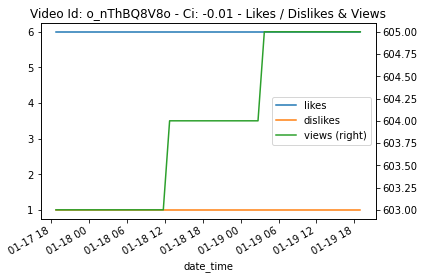

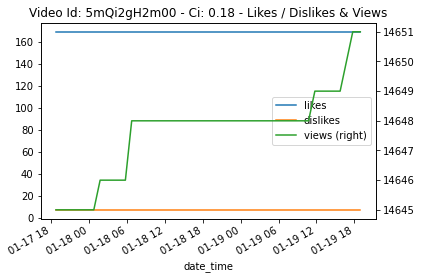

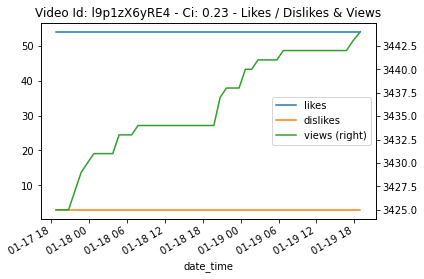

In [40]:
for i in bott3 :
#     print('i')
    datad=df_48h_bott3[df_48h_bott3.video_id == i]
    ci = df_vid[df_vid['video_id'] == i]['ci'].values[0]
    
    fig, ax = plt.subplots()
    datad.plot(x = 'date_time', y = ['likes','dislikes'], ax = ax) 
    datad.plot(x = 'date_time', y = 'views', ax = ax, secondary_y = True)
    plt.title('Video Id: ' + i + ' - Ci: ' + str(ci) + ' - Likes / Dislikes & Views')

#### Videos with maximum ci

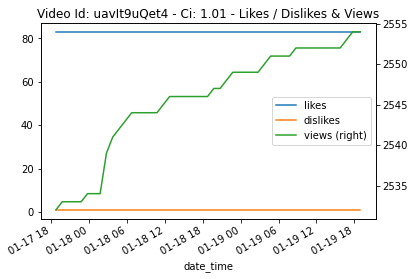

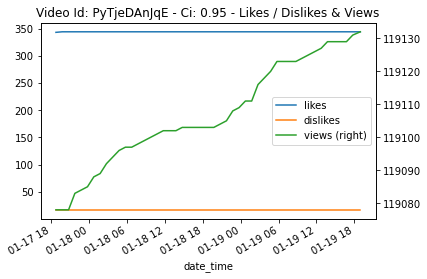

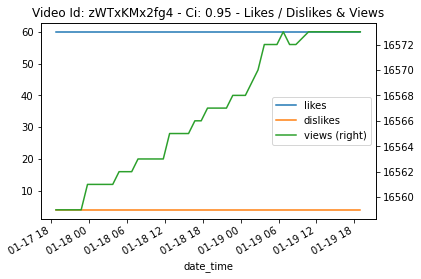

In [37]:
for i in top3 :
#     print('i')
    datad=df_48h_top3[df_48h_top3.video_id == i]
    ci = df_vid[df_vid['video_id'] == i]['ci'].values[0]
    
    fig, ax = plt.subplots()
    datad.plot(x = 'date_time', y = ['likes','dislikes'], ax = ax) 
    datad.plot(x = 'date_time', y = 'views', ax = ax, secondary_y = True)
    plt.title('Video Id: ' + i + ' - Ci: ' + str(ci) + ' - Likes / Dislikes & Views')

### Merge DataFrames into one 

In [27]:
df = aggdf[['video_id',"views_last",'p','r',"LPV","DPV","VDP"]].merge(df_vid, on='video_id', how='inner') 


### Normalize data using z-score

In [28]:
cols_to_norm = ["views_last",'p','r',"LPV","DPV","VDP",'ci','duration']
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: zscore(x,nan_policy="omit"))

In [29]:
df.head(10)

,video_id,views_last,p,r,LPV,DPV,VDP,duration,ci
0,-GfymQXwt78,-0.198240,0.57104,0.609489,-0.212677,-0.159796,-0.030043,-0.194774,0.183374
1,-OZLEczfc6o,1.127032,-1.75119,-0.383244,-0.061915,0.208112,5.156800,0.181435,-0.596514
2,-rPipouU4sQ,-0.207825,0.57104,2.634019,-0.226449,-0.159796,-0.107014,-0.184025,-0.553187
3,-sDq32LbQJE,-0.120330,0.57104,0.090711,-0.240028,-0.159796,1.335902,-0.184025,0.443337
4,-vnVOvVoFDE,-0.204963,NaN,-0.478069,-0.275043,-0.159796,-0.556220,-0.278375,-1.159767
5,06wuL1L18Ms,-0.009391,-1.75119,-0.436100,-0.162872,0.227469,-0.069139,-0.198357,-0.986458
6,0DHBKDNEcOQ,-0.179225,0.57104,0.322906,-0.216294,-0.159796,0.380067,-0.182830,0.616646
7,0Q1ObpoovcM,-0.154655,0.57104,-0.459100,-0.157240,-0.159796,-0.469067,-0.309428,1.136571
8,0_C2HJvtRDY,13.483951,-1.75119,-0.497874,-0.009086,-0.017806,3.478896,-0.467077,-0.293224
9,0gV0Q01nqIc,-0.162949,NaN,-0.447518,-0.275043,-0.159796,-0.462958,-0.477826,-1.029785


### Correlation Matrix for indexes

<AxesSubplot:>

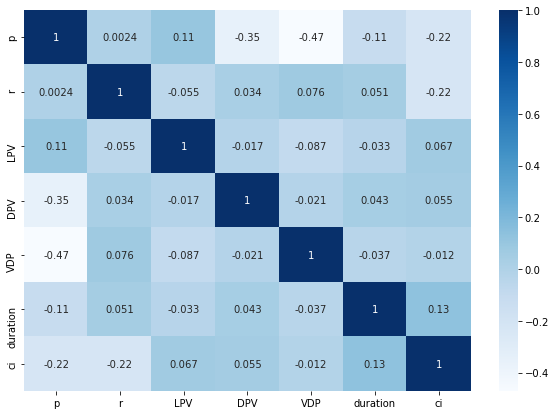

In [52]:
cormatrix = df.iloc[:,2:].corr(method = 'pearson') 
plt.figure(figsize = (10,7))
sns.heatmap(cormatrix, annot = True,cmap="Blues", )

### Pair plot for indexes

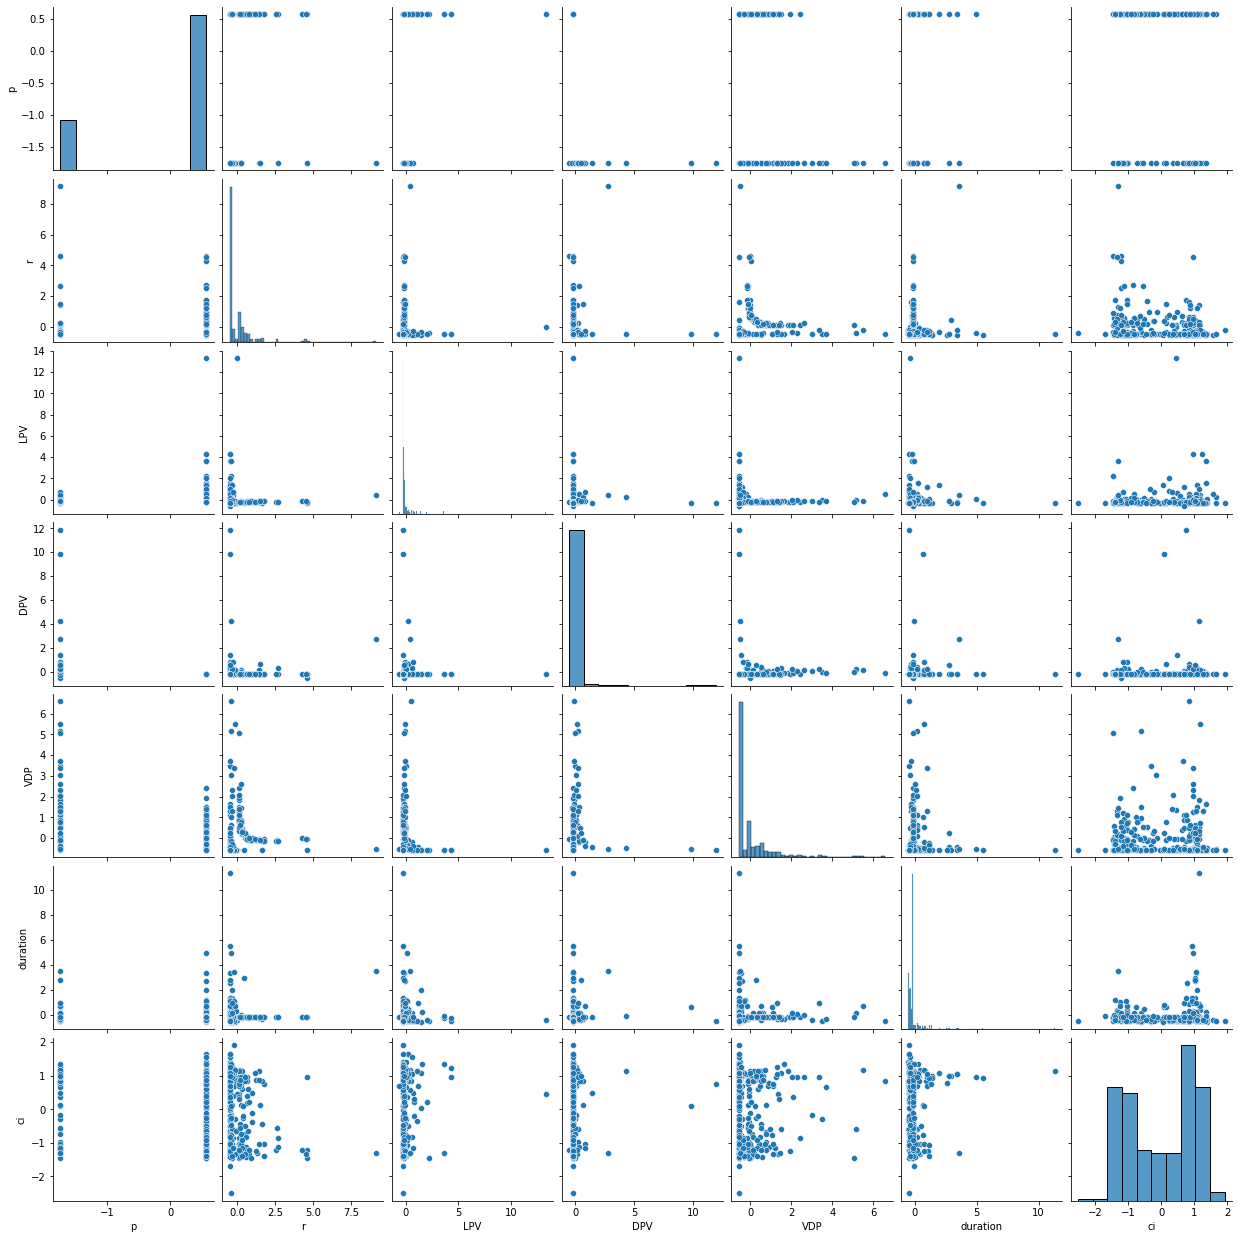

In [31]:
sns.pairplot(df.iloc[:,2:])
# plt.show()

### Plot for 150 first videos order by views

<AxesSubplot:ylabel='video_id'>

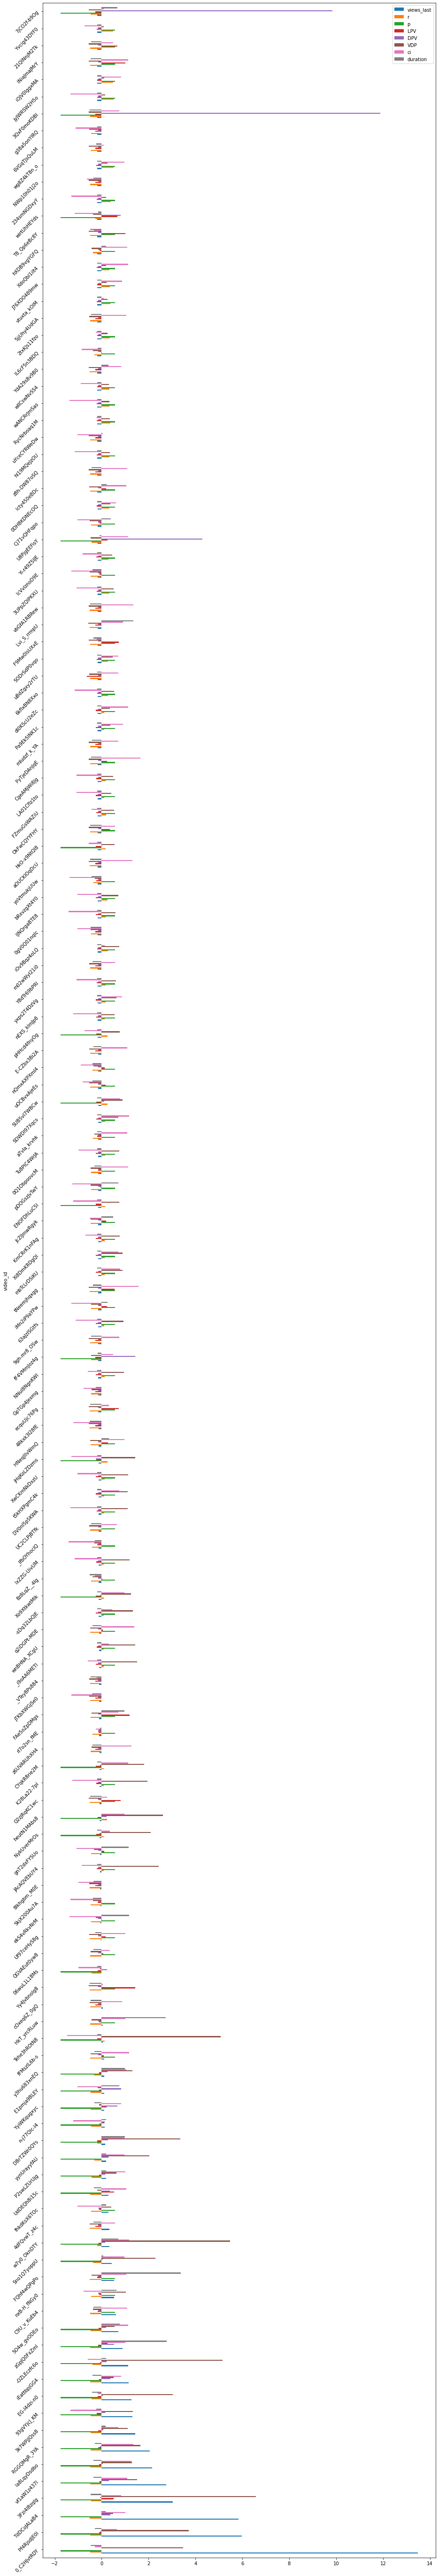

In [36]:
dfplot= df.sort_values('views_last', ascending= False).head(150)
dfplot.plot.barh(x = 'video_id', y = ["views_last","r","p","LPV","DPV","VDP",'ci','duration'], rot=45, figsize=(15,100))

In [56]:
conn.close()

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
x_coords = np.linspace(-200, 200, 600) 
y_coords = np.linspace(-200, 200, 600)
heart_x = []
heart_y = [] 
for y in y_coords: 
    for x in x_coords: 
        if ((x*0.01)**2+(y*0.01)**2-1)**3-(x*0.01)**2*(y*0.01)**3 <= 0:
            heart_x.append(x) 
            heart_y.append(y) 
plt.scatter(heart_x, heart_y, c="red") 
plt.axis('off') 
plt.show()